# SEER Breast Cancer Dataset 

## About this notebook

This notebook demonstrates explorative data analyses steps to prepare a basic machine learning model for a classification problem.
The analyses includes:
* a general overview of the data (via basic basic python and pandas) 
* data exploration steps of categorical and numerical columns via plotting (bar plots, histograms, box plots) (matplotlib, seaborn)
* basic data cleaning steps (the data set used was already clean and only smaller changes of typos and data types were necessary)
* exploration and visualization of correlations in the data (via corr(), scatterplot(), pairplot(), seaborn.heatmap())
* train-test-split of the data (via sklearn - train_test_split())
* re-mapping and encoding of columns (map(), OneHotEncoder())
* instantiation of a basic DecisionTreeClassifier pipeline (via sklearn - DecisionTreeClassifier, imblearn - Pipeline)
* testing of four different re-sampling methods on a basic DecisionTreeModel (via imblearn, sklearn) 
* extracting and visualization of feature importances and plotting a tree for the basic model (sklearn - graphviz)
* confusion_matrix, roc_auc_score, roc_curve

## About the dataset
This SEER cancer dataset was obtained from an 2017 update of the SEER (The Surveillance, Epidemiology, and End Results)
NCI program. It was uploaded to U-BRITE for "AI against CANCER DATA SCIENCE HACKATHON" (https://cancer.ubrite.org/hackathon-2021/) and can also be found on Kaggle.com.
The dataset involved female patients with infiltrating duct and lobular carcinoma breast cancer (SEER primary cites recode NOS histology codes 8522/3) diagnosed in 2006-2010. Patients with unknown tumour size, examined regional LNs, positive regional LNs, and patients whose survival months were less than 1 month were excluded; thus, 4024 patients were ultimately included.
The target variable contains the values 'Alive' and 'Dead'. Any patient that died after the follow-up cut-off in 2017 was recorded to be alive as of the cut-off date. 

Licence: Attribution 4.0 International (CC BY 4.0) 

## Contributers to the notebook: 


In [9]:
# EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#useful imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
plt.style.use('seaborn')

C:\Users\bmerg\AppData\Local\Temp\ipykernel_19852\1518990824.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [10]:
# reading in data as df and checking info
df = pd.read_csv('Breast_Cancer.csv', delimiter=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [11]:
# checking for NaNs
df.isna().sum()

Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64

In [12]:
# creating a list of all column names
all_cols = []
for col in df.columns:
    all_cols.append(col)

# overview of values and n_uniques for all columns
for col in all_cols:
    print(f'{col}: {df.loc[:,col].unique()}, nunique: {df.loc[:,col].nunique()}\n')

Age: [68 50 58 47 51 40 69 46 65 48 62 61 56 43 60 57 55 63 66 53 59 54 49 64
 42 37 67 31 52 33 45 38 39 36 41 44 32 34 35 30], nunique: 40

Race: ['White' 'Black' 'Other'], nunique: 3

Marital Status: ['Married' 'Divorced' 'Single ' 'Widowed' 'Separated'], nunique: 5

T Stage : ['T1' 'T2' 'T3' 'T4'], nunique: 4

N Stage: ['N1' 'N2' 'N3'], nunique: 3

6th Stage: ['IIA' 'IIIA' 'IIIC' 'IIB' 'IIIB'], nunique: 5

differentiate: ['Poorly differentiated' 'Moderately differentiated' 'Well differentiated'
 'Undifferentiated'], nunique: 4

Grade: ['3' '2' '1' ' anaplastic; Grade IV'], nunique: 4

A Stage: ['Regional' 'Distant'], nunique: 2

Tumor Size: [  4  35  63  18  41  20   8  30 103  32  13  59  15  19  46  24  25  29
  40  70  22  50  17  21  10  27  23   5  51   9  55 120  77   2  11  12
  26  75 130  34  80   3  60  14  16  45  36  76  38  49   7  72 100  43
  62  37  68  52  85  57  39  28  48 110  65   6 105 140  42  31  90 108
  98  47  54  61  74  33   1  87  81  58 117  44 123 13

In [13]:
# creating dict to change dtypes of columns
# some columns are ordinal, this needs to be changed after EDA

# correcting a typo in column 'T Stage'
df = df.rename(columns={'T Stage ':'T Stage'})

# creating dictionairy with correct dtypes
dtypes_columns = {'Age' : 'int64',
'Race' : 'category',
'Marital Status' : 'category',
'T Stage' : 'category', 
'N Stage' : 'category',
'6th Stage' : 'category',
'differentiate' : 'category',
'Grade' : 'category',
'A Stage' : 'category', 
'Tumor Size' : 'int64',
'Estrogen Status' : 'category',
'Progesterone Status' : 'category',
'Regional Node Examined' : 'int64',
'Reginol Node Positive' : 'int64',
'Survival Months' : 'int64',
'Status' : 'category'}

# setting dtypes
df = df.astype(dtypes_columns)

df.info()

# creating cat_cols and num_cols lists
all_cols = []
for col in df.columns:
    all_cols.append(col)
num_cols = []
cat_cols = []
for col in dtypes_columns:
    if dtypes_columns[col] == 'category':
        cat_cols.append(col)
    elif dtypes_columns[col] == 'int64' or dtypes_columns[col] == 'int32':
        num_cols.append(col)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Age                     4024 non-null   int64   
 1   Race                    4024 non-null   category
 2   Marital Status          4024 non-null   category
 3   T Stage                 4024 non-null   category
 4   N Stage                 4024 non-null   category
 5   6th Stage               4024 non-null   category
 6   differentiate           4024 non-null   category
 7   Grade                   4024 non-null   category
 8   A Stage                 4024 non-null   category
 9   Tumor Size              4024 non-null   int64   
 10  Estrogen Status         4024 non-null   category
 11  Progesterone Status     4024 non-null   category
 12  Regional Node Examined  4024 non-null   int64   
 13  Reginol Node Positive   4024 non-null   int64   
 14  Survival Months         

In [14]:
# small function to explore cat_cols
def cat_col_explorer(data, cat_cols, target_name):
    """Displays graphs to explore categorical columns by target.
       
    Args: 
        df (pd.DataFrame) : DataFrame
        cat_cols(list) : list of categorical columns to use
        target_name(str) : string of the target variable
    Returns:
        displays barplots
    """
    for col in cat_cols:
        print(pd.crosstab(index=df.loc[:, col],
                    columns = df.loc[:,target_name], 
                    normalize=True))
        
        pd.crosstab(index=df.loc[:, col],
                    columns = df.loc[:,target_name], 
                    normalize=False).plot(kind='bar')
        
        
        plt.show()


Status     Alive      Dead
Race                      
Black   0.054175  0.018141
Other   0.071322  0.008201
White   0.721421  0.126740


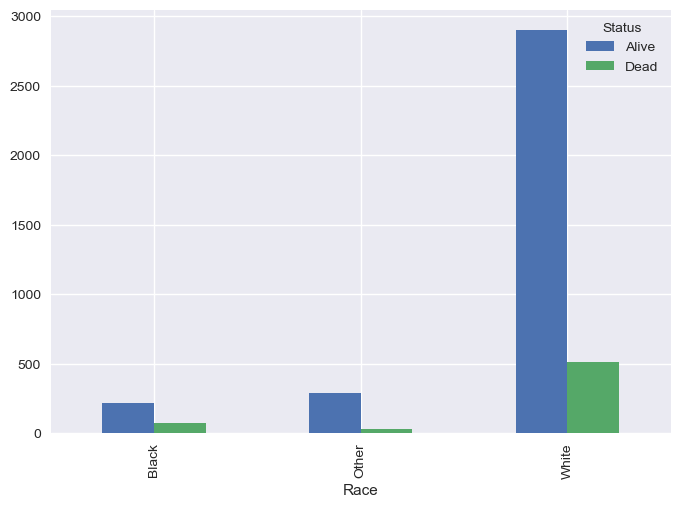

Status             Alive      Dead
Marital Status                    
Divorced        0.098410  0.022366
Married         0.567843  0.088966
Separated       0.007455  0.003728
Single          0.126988  0.025845
Widowed         0.046223  0.012177


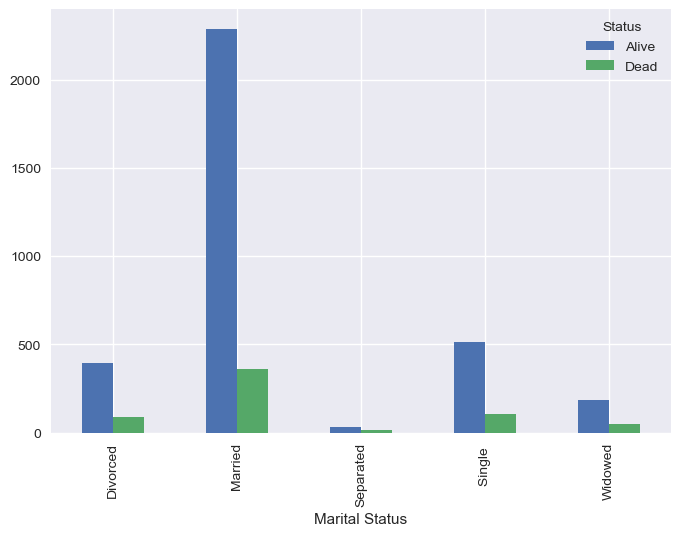

Status      Alive      Dead
T Stage                    
T1       0.359344  0.039016
T2       0.368539  0.075298
T3       0.103628  0.028827
T4       0.015408  0.009940


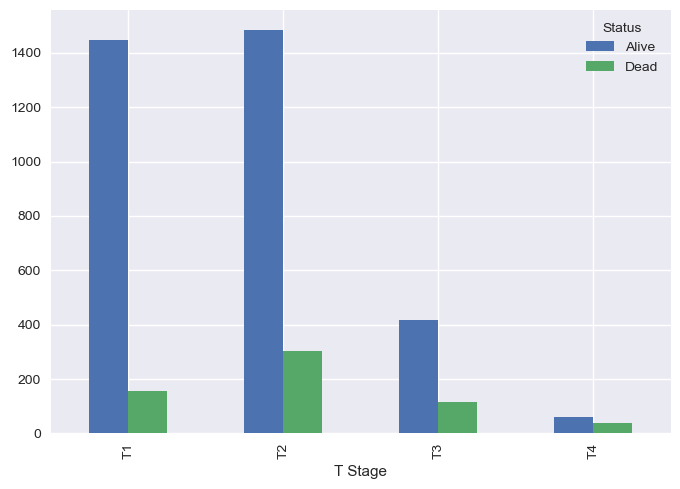

Status      Alive      Dead
N Stage                    
N1       0.611829  0.067097
N2       0.162773  0.041004
N3       0.072316  0.044980


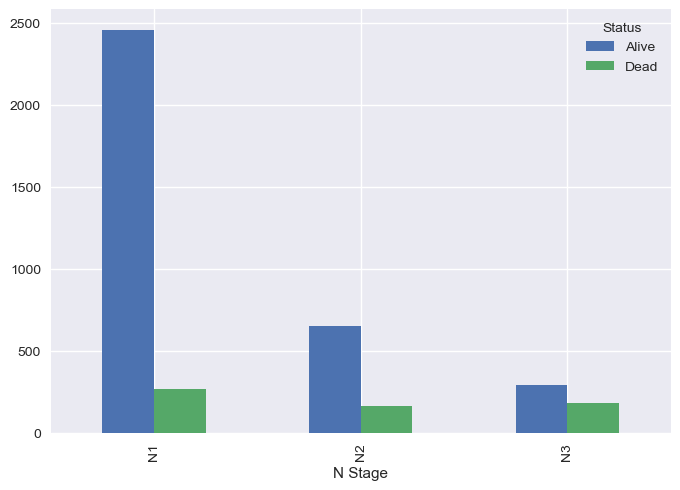

Status        Alive      Dead
6th Stage                    
IIA        0.300447  0.023857
IIB        0.247266  0.033549
IIIA       0.215209  0.045726
IIIB       0.011680  0.004970
IIIC       0.072316  0.044980


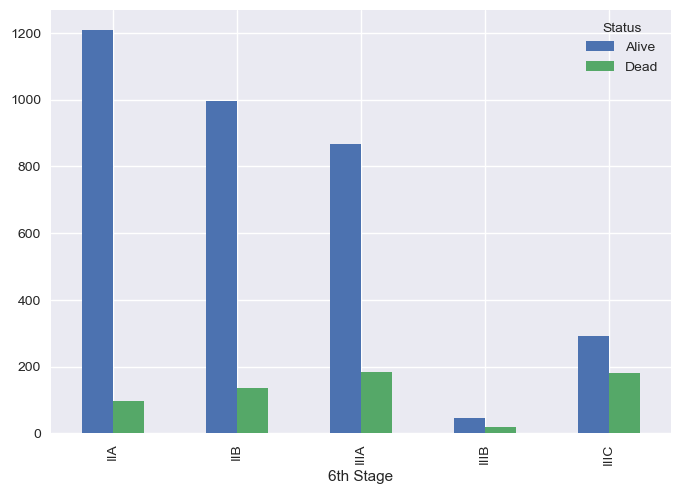

Status                        Alive      Dead
differentiate                                
Moderately differentiated  0.508449  0.075795
Poorly differentiated      0.210736  0.065358
Undifferentiated           0.002485  0.002237
Well differentiated        0.125249  0.009692


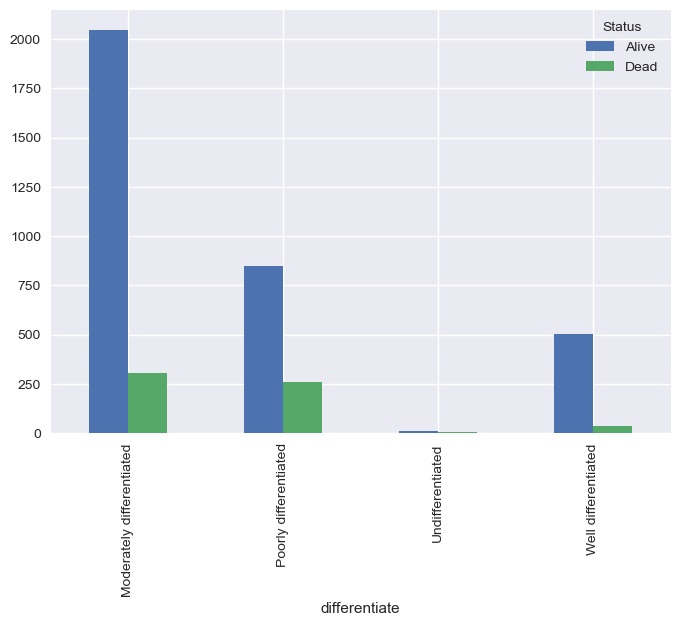

Status                    Alive      Dead
Grade                                    
 anaplastic; Grade IV  0.002485  0.002237
1                      0.125249  0.009692
2                      0.508449  0.075795
3                      0.210736  0.065358


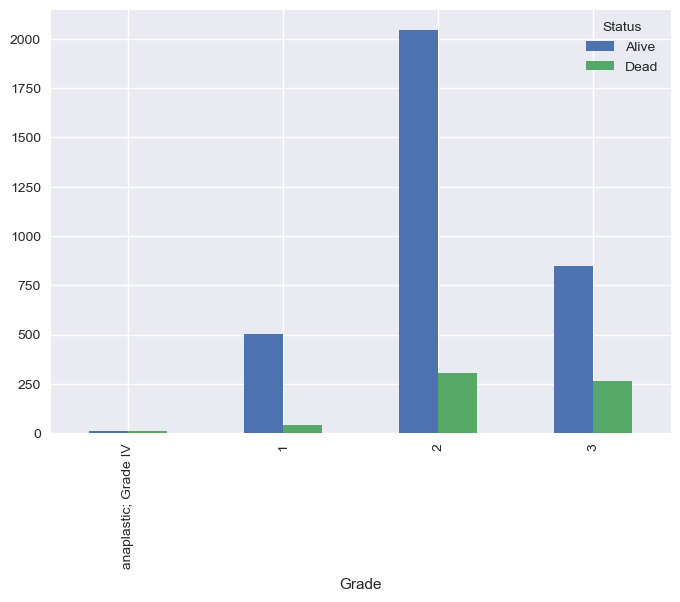

Status       Alive      Dead
A Stage                     
Distant   0.014165  0.008698
Regional  0.832753  0.144384


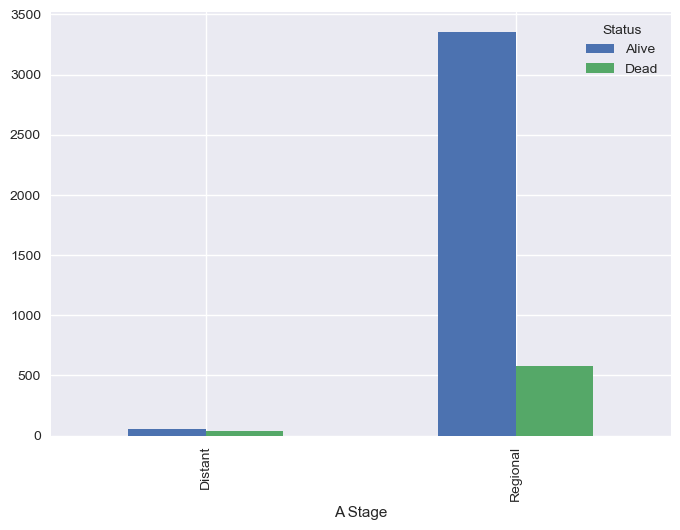

Status              Alive      Dead
Estrogen Status                    
Negative         0.040010  0.026839
Positive         0.806909  0.126243


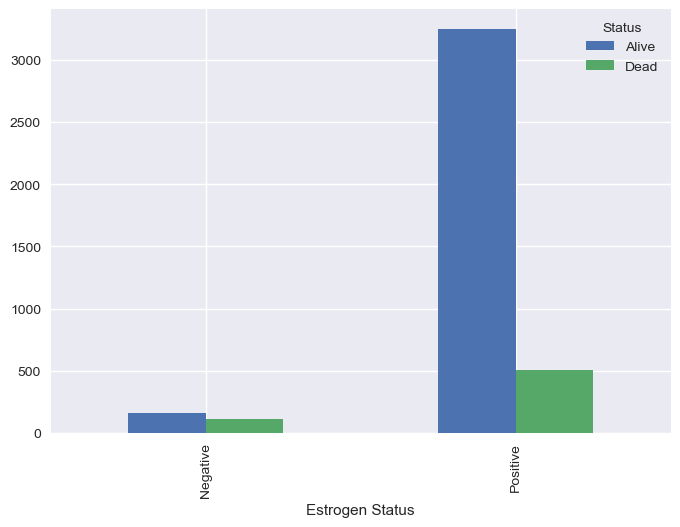

Status                  Alive      Dead
Progesterone Status                    
Negative             0.122763  0.050696
Positive             0.724155  0.102386


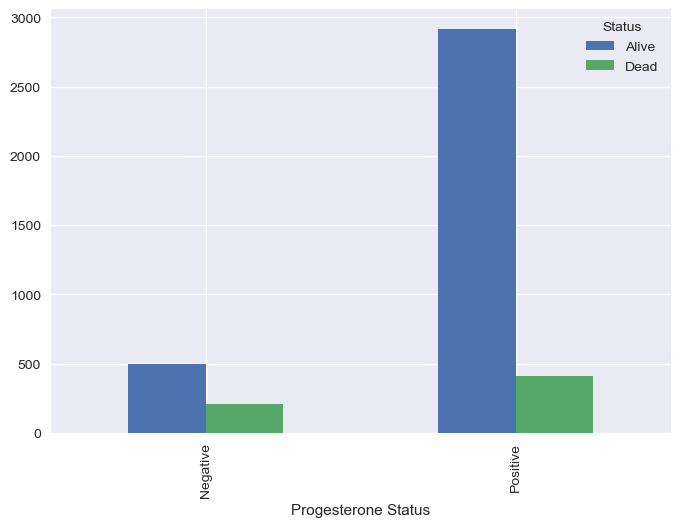

Status     Alive      Dead
Status                    
Alive   0.846918  0.000000
Dead    0.000000  0.153082


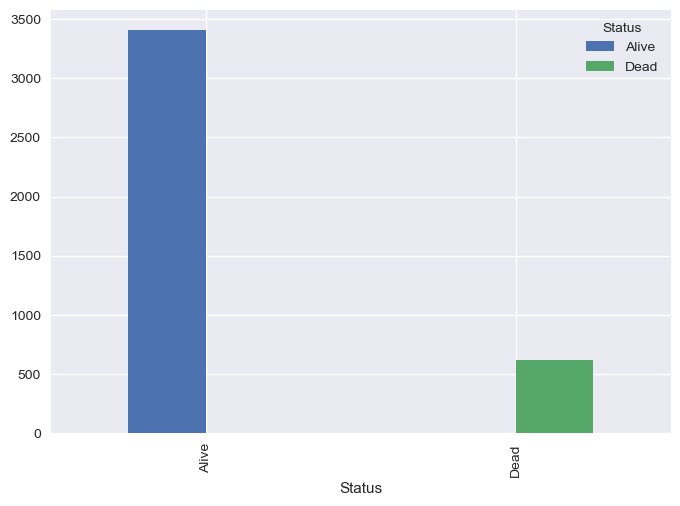

In [15]:
# running function
cat_col_explorer(df, cat_cols, 'Status')

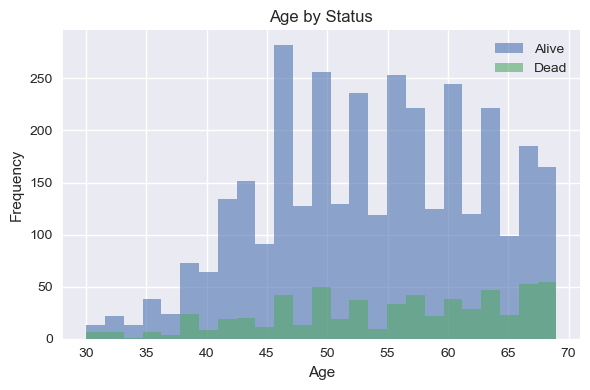

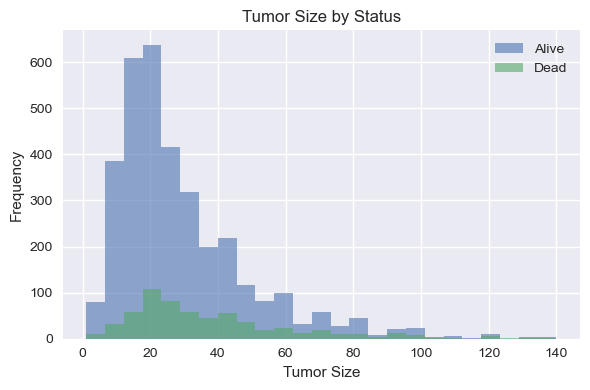

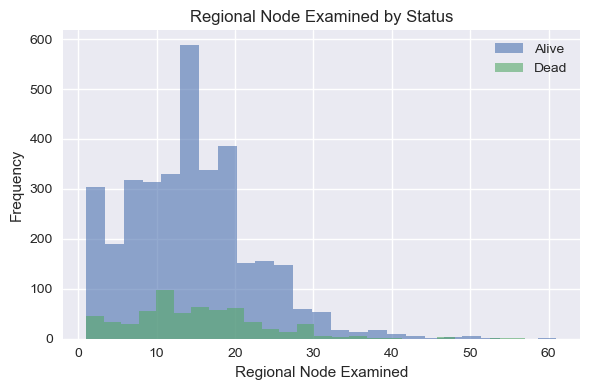

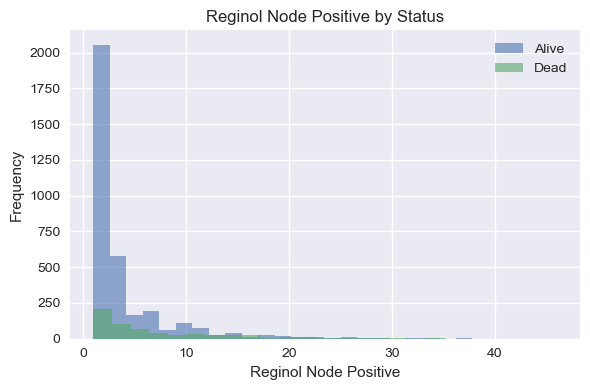

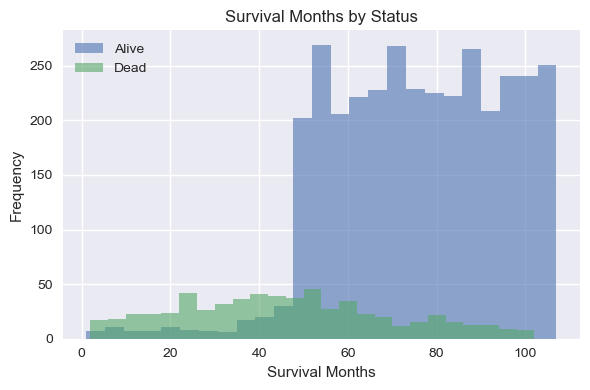

In [16]:
# exploring num_cols with hist plots
for col in num_cols:
    fig, ax = plt.subplots(figsize=(6,4))
    df.groupby('Status')[col].plot(kind='hist',legend=True, bins=25, alpha=0.6, ax=ax)
    ax.set(title=col+' by Status', xlabel=col)
    plt.tight_layout()

In [17]:
# checking numerical columns with describe
df.describe()

Age   Tumor Size  Regional Node Examined  \
count  4024.000000  4024.000000             4024.000000   
mean     53.972167    30.473658               14.357107   
std       8.963134    21.119696                8.099675   
min      30.000000     1.000000                1.000000   
25%      47.000000    16.000000                9.000000   
50%      54.000000    25.000000               14.000000   
75%      61.000000    38.000000               19.000000   
max      69.000000   140.000000               61.000000   

       Reginol Node Positive  Survival Months  
count            4024.000000      4024.000000  
mean                4.158052        71.297962  
std                 5.109331        22.921430  
min                 1.000000         1.000000  
25%                 1.000000        56.000000  
50%                 2.000000        73.000000  
75%                 5.000000        90.000000  
max                46.000000       107.000000

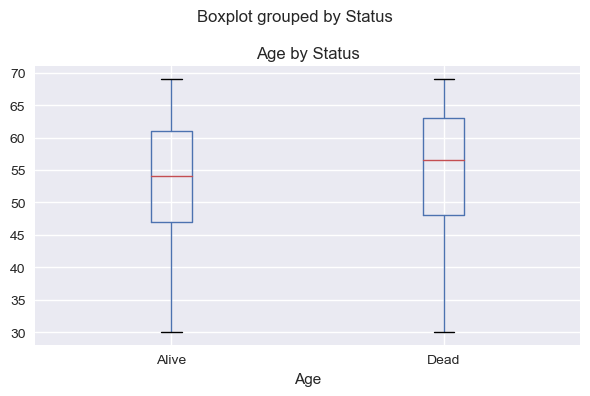

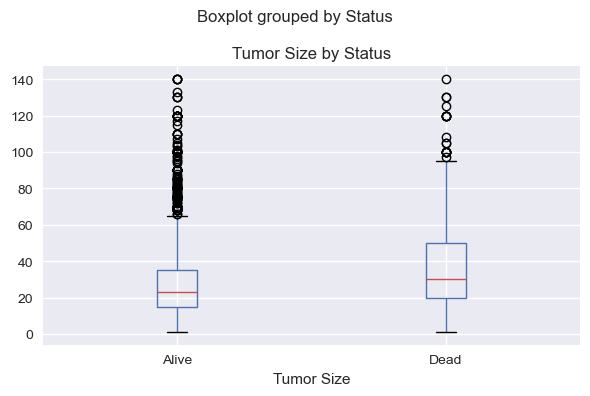

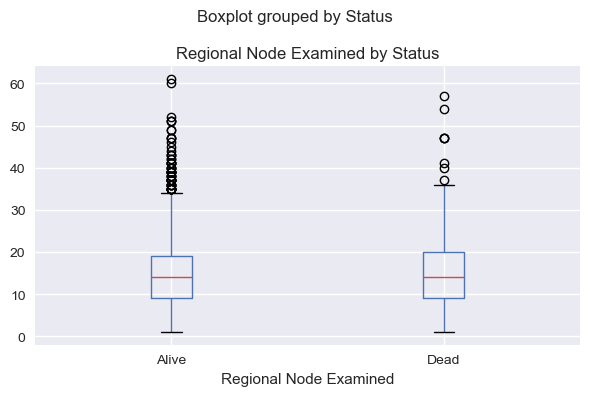

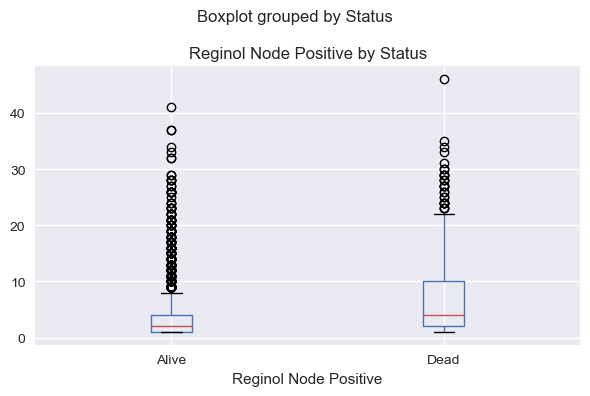

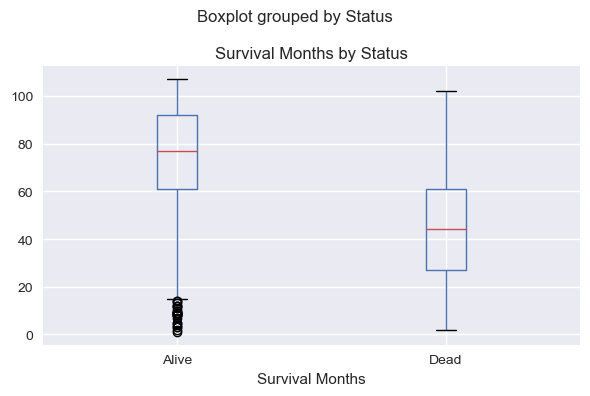

In [18]:
# Quick overview - boxplots: df grouped by 'Status' and for num_cols
for col in num_cols:
    fig2, ax = plt.subplots(figsize=(6,4))
    df.boxplot(column=col, by='Status', ax=ax)
    ax.set(title=col+' by Status', xlabel=col)

    plt.tight_layout()

In [19]:
# correcting typo
df = df.rename(columns={'T Stage ':'T Stage'})

# remapping ordinal columns for EDA
df.loc[:,'Status_encoded'] = df.loc[:,'Status'].map({'Alive':0, 'Dead':1})
df.loc[:,'T Stage'] = df.loc[:,'T Stage'].map({'T1':0, 'T2':1, 'T3':2, 'T4':3})
df.loc[:,'N Stage'] = df.loc[:,'N Stage'].map({'N1':0, 'N2':1, 'N3':2})
df.loc[:,'6th Stage'] = df.loc[:,'6th Stage'].map({'IIA':0, 'IIIA':1, 'IIIC':2, 'IIB':3, 'IIIB':4})
df.loc[:,'differentiate'] = df.loc[:,'differentiate'].map({'Poorly differentiated':2, 
                                                           'Moderately differentiated':1,
                                                             'Well differentiated':0,
                                                             'Undifferentiated':3})
df.loc[:,'Grade'] = df.loc[:,'Grade'].map({'3':2,
                                            '2':1,
                                            '1':0,
                                            ' anaplastic; Grade IV': 3})
df.loc[:,'A Stage'] = df.loc[:,'A Stage'].map({'Regional':0, 'Distant':1})

dtypes_columns = {'Age' : 'int64',
'Race' : 'category',
'Marital Status' : 'category',
'T Stage' : 'int64', 
'N Stage' : 'int64',
'6th Stage' : 'int64',
'differentiate' : 'int64',
'Grade' : 'int64',
'A Stage' : 'int64', 
'Tumor Size' : 'int64',
'Estrogen Status' : 'category',
'Progesterone Status' : 'category',
'Regional Node Examined' : 'int64',
'Reginol Node Positive' : 'int64',
'Survival Months' : 'int64',
'Status' : 'category',
'Status_encoded' : 'int64'}
df = df.astype(dtypes_columns)

In [20]:
# correlation numbers
corr = df.corr(numeric_only=True)
corr

Age   T Stage   N Stage  6th Stage  \
Age                     1.000000 -0.066914  0.002883  -0.044969   
T Stage                -0.066914  1.000000  0.277015   0.563704   
N Stage                 0.002883  0.277015  1.000000   0.093911   
6th Stage              -0.044969  0.563704  0.093911   1.000000   
differentiate          -0.099294  0.131470  0.162501   0.097191   
Grade                  -0.099294  0.131470  0.162501   0.097191   
A Stage                -0.020860  0.221124  0.260573   0.137213   
Tumor Size             -0.077215  0.809176  0.277905   0.303358   
Regional Node Examined -0.033345  0.114102  0.328276   0.082604   
Reginol Node Positive   0.012586  0.243075  0.838073   0.142749   
Survival Months        -0.009390 -0.085718 -0.139577  -0.053633   
Status_encoded          0.055921  0.154699  0.255772   0.091873   

                        differentiate     Grade   A Stage  Tumor Size  \
Age                         -0.099294 -0.099294 -0.020860   -0.077215   
T Stage                      0.131470  0.131470  0.221124    0.809176   
N Stage                      0.162501  0.162501  0.260573    0.277905   
6th Stage                    0.097191  0.097191  0.137213    0.303358   
differentiate                1.000000  1.000000  0.039459    0.119367   
Grade                        1.000000  1.000000  0.039459    0.119367   
A Stage                      0.039459  0.039459  1.000000    0.123883   
Tumor Size                   0.119367  0.119367  0.123883    1.000000   
Regional Node Examined       0.084416  0.084416  0.069010    0.104352   
Reginol Node Positive        0.135319  0.135319  0.232849    0.242322   
Survival Months             -0.067669 -0.067669 -0.070109   -0.086901   
Status_encoded               0.161398  0.161398  0.096584    0.134205   

                        Regional Node Examined  Reginol Node Positive  \
Age                                  -0.033345               0.012586   
T Stage                               0.114102               0.243075   
N Stage                               0.328276               0.838073   
6th Stage                             0.082604               0.142749   
differentiate                         0.084416               0.135319   
Grade                                 0.084416               0.135319   
A Stage                               0.069010               0.232849   
Tumor Size                            0.104352               0.242322   
Regional Node Examined                1.000000               0.411580   
Reginol Node Positive                 0.411580               1.000000   
Survival Months                      -0.022054              -0.135214   
Status_encoded                        0.034772               0.256638   

                        Survival Months  Status_encoded  
Age                           -0.009390        0.055921  
T Stage                       -0.085718        0.154699  
N Stage                       -0.139577        0.255772  
6th Stage                     -0.053633        0.091873  
differentiate                 -0.067669        0.161398  
Grade                         -0.067669        0.161398  
A Stage                       -0.070109        0.096584  
Tumor Size                    -0.086901        0.134205  
Regional Node Examined        -0.022054        0.034772  
Reginol Node Positive         -0.135214        0.256638  
Survival Months                1.000000       -0.476514  
Status_encoded                -0.476514        1.000000

<Axes: >

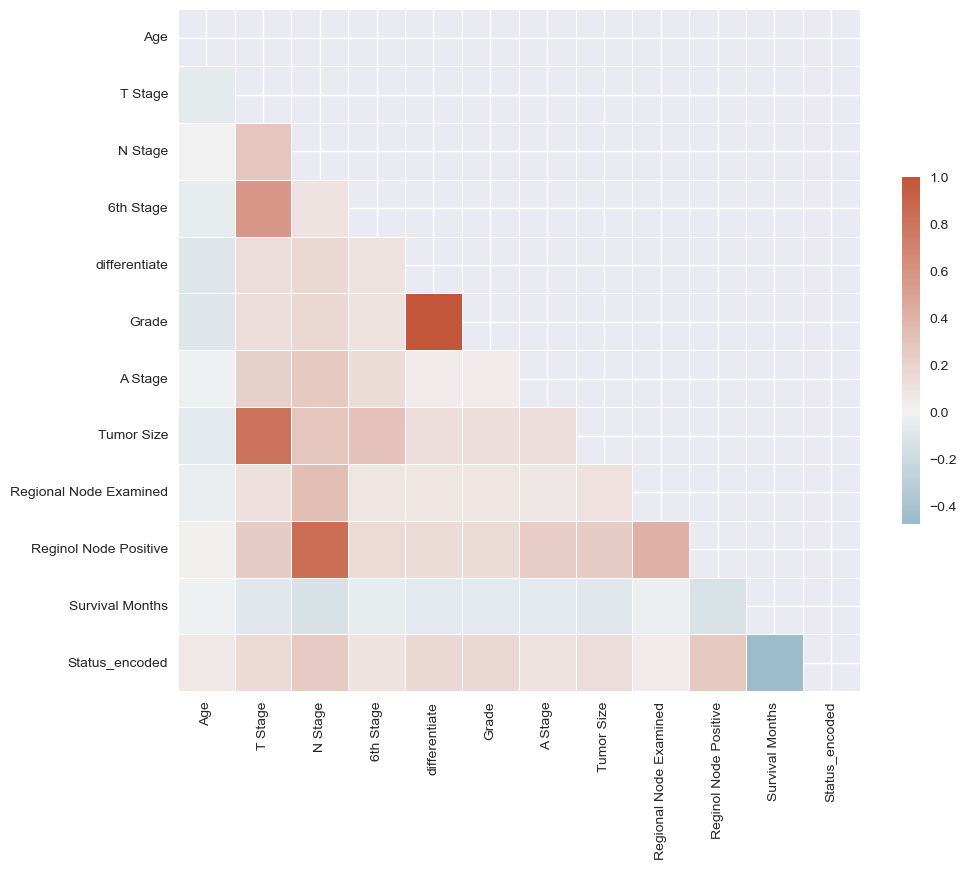

In [21]:
# correlation matrix

# code is from here: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

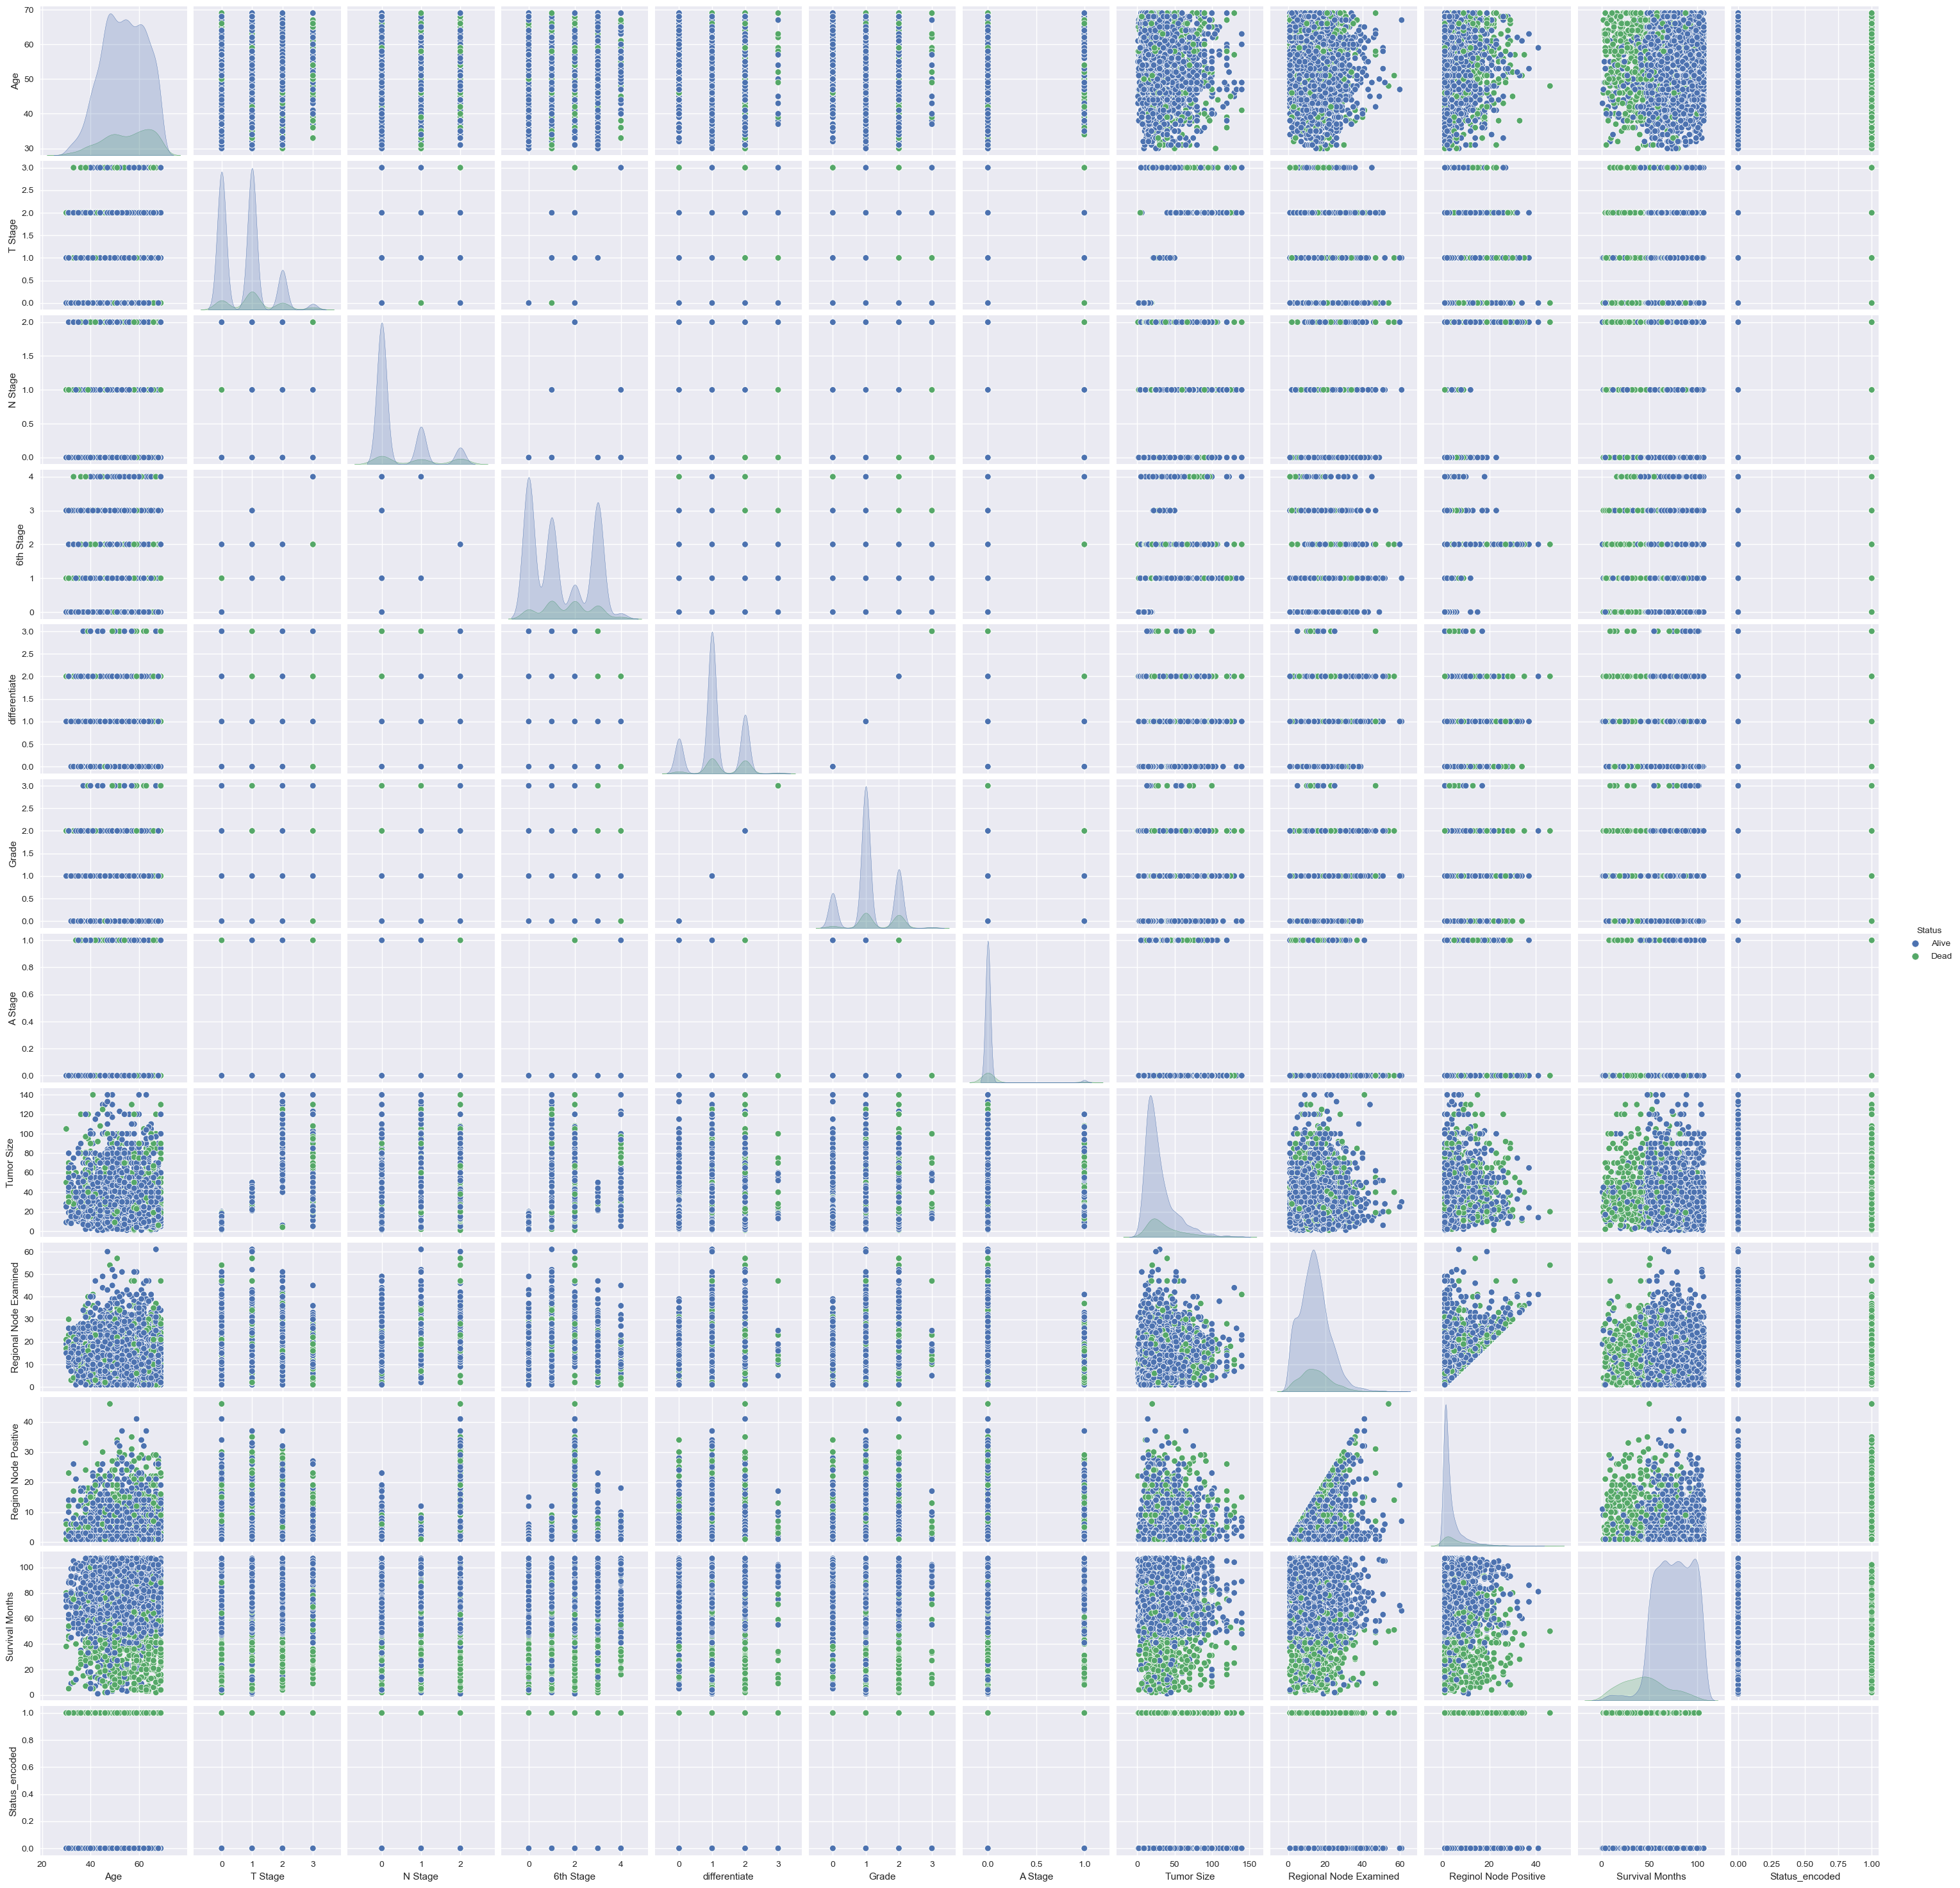

In [29]:
# creating pairplot and saving pairplot as png file for later use
png_pairplot = sns.pairplot(df, hue='Status')
png_pairplot.savefig('png_pairplot.png')

In [30]:
# perform train-test-split - original csv file is imported again to start with a clean df

# import modules
from sklearn.model_selection import train_test_split

# reading in data as df
df = pd.read_csv('Breast_Cancer.csv', delimiter=',')

# correcting typo
df = df.rename(columns={'T Stage ':'T Stage'})
df = df.rename(columns={'Reginol Node Positive'})

# remapping ordinal columns - steps will be moved to pipeline later
df.loc[:,'Status_encoded'] = df.loc[:,'Status'].map({'Alive':0, 'Dead':1})
df.loc[:,'T Stage'] = df.loc[:,'T Stage'].map({'T1':0, 'T2':1, 'T3':2, 'T4':3})
df.loc[:,'N Stage'] = df.loc[:,'N Stage'].map({'N1':0, 'N2':1, 'N3':2})
df.loc[:,'6th Stage'] = df.loc[:,'6th Stage'].map({'IIA':0, 'IIIA':1, 'IIIC':2, 'IIB':3, 'IIIB':4})
df.loc[:,'differentiate'] = df.loc[:,'differentiate'].map({'Poorly differentiated':0, 
                                                           'Moderately differentiated':1,
                                                             'Well differentiated':2,
                                                             'Undifferentiated':3})
df.loc[:,'Grade'] = df.loc[:,'Grade'].map({'3':2,
                                            '2':1,
                                            '1':0,
                                            ' anaplastic; Grade IV': 3})
df.loc[:,'A Stage'] = df.loc[:,'A Stage'].map({'Regional':0, 'Distant':1})

# changing dtypes of columns as needed
dtypes_columns = {'Age' : 'int64',
'Race' : 'category',
'Marital Status' : 'category',
'T Stage' : 'int64', 
'N Stage' : 'int64',
'6th Stage' : 'int64',
'differentiate' : 'int64',
'Grade' : 'int64',
'A Stage' : 'int64', 
'Tumor Size' : 'int64',
'Estrogen Status' : 'category',
'Progesterone Status' : 'category',
'Regional Node Examined' : 'int64',
'Reginol Node Positive' : 'int64',
'Survival Months' : 'int64',
'Status' : 'category',
'Status_encoded' : 'int64'}
df = df.astype(dtypes_columns)

# creating target and features 
target = df.loc[:,'Status_encoded']
features = df.drop('Status', axis=1)
features = features.drop('Status_encoded', axis=1)

# train and test split
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            random_state=42,
                                                                            test_size=0.1)

In [31]:
# save features_test as 'features_test.csv'
features_test.to_csv('features_test.csv', index=False)

In [34]:
# creating list of numerical columns and categorical columns for later use
num_cols = []
cat_cols = []
for col in features_train.columns:
    if features_train[col].dtype == 'category':
        cat_cols.append(col)
    elif features_train[col].dtype == 'int64' or 'float64':
        num_cols.append(col)

#check
print(f'cat + num cols: {len(cat_cols) + len(num_cols)}\n')
print(f'num_cols: {num_cols}\n')
print(f'cat_cols: {cat_cols}')


cat + num cols: 15

num_cols: ['Age', 'T Stage', 'N Stage', '6th Stage', 'differentiate', 'Grade', 'A Stage', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']

cat_cols: ['Race', 'Marital Status', 'Estrogen Status', 'Progesterone Status']


In [36]:
# only needed for next step - checking resampling strategies
# one hot encoding for the model is moved to pipeline

# two functions to ensure that OneHotEncoder is only fitted on training data
def engineer_features_train(data):
    # Apply one-hot encoder to each column with categorical data
    ohe_transformer = OneHotEncoder(sparse=False, drop='if_binary')
    ohe_transformer.fit(data[cat_cols])
    df_ohe = pd.DataFrame(ohe_transformer.transform(data[cat_cols]))

    # One-hot encoding, reindex and return column names
    feature_names = ohe_transformer.get_feature_names_out(cat_cols)
    df_ohe.index = data[cat_cols].index
    df_ohe.columns = feature_names

    # Add one-hot encoded columns to numerical features
    df_num_ohe = pd.concat([data[num_cols], df_ohe], axis=1)
    return df_num_ohe
# running function
features_train_ohe = engineer_features_train(features_train)

def engineer_features_test(data):
    # Apply one-hot encoder to each column with categorical data
    ohe_transformer = OneHotEncoder(sparse=False, drop='if_binary')
    ohe_transformer.fit(features_train[cat_cols])
    df_ohe = pd.DataFrame(ohe_transformer.transform(data[cat_cols]))

    # One-hot encoding, reindex and return column names
    feature_names = ohe_transformer.get_feature_names_out(cat_cols)
    df_ohe.index = data[cat_cols].index
    df_ohe.columns = feature_names

    # Add one-hot encoded columns to numerical features
    df_num_ohe = pd.concat([data[num_cols], df_ohe], axis=1)
    return df_num_ohe
# running function
features_test_ohe = engineer_features_test(features_test)


c:\Users\bmerg\anaconda3\envs\portfolio_minimal_ds\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\bmerg\anaconda3\envs\portfolio_minimal_ds\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [37]:
# checking resampling strategies

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline # pipeline builder can handle 

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

features_train_resample = features_train_ohe
features_test_resample = features_test_ohe
        
undersampler = RandomUnderSampler(random_state=42)
oversampler = RandomOverSampler(random_state=42)
smotesampler = SMOTE(random_state=42)

tree_clf = DecisionTreeClassifier(random_state=42)
search_space = {'estimator__max_depth': range(2, 16, 2),
                'estimator__class_weight': [None, 'balanced']}
samplers = [('oversampling', oversampler),
            ('undersampling', undersampler),
            ('class_weights', 'passthrough'),
            ('SMOTE', smotesampler)
           ]
results = []

# go through every sampler
for name, sampler in samplers:
    # sampling
    imb_pipe = Pipeline([('sampler', sampler),
                         ('estimator', tree_clf)
                        ])
    
    # gridsearch and CV
    grid = GridSearchCV(estimator=imb_pipe, 
                        param_grid=search_space,
                        n_jobs=-1,
                        cv=5,
                        scoring='f1')
    
    grid.fit(features_train_resample, target_train)
    
    # evaluation
    model = grid.best_estimator_.named_steps['estimator']
    recall = recall_score(target_test, model.predict(features_test_resample))
    precision = precision_score(target_test, model.predict(features_test_resample))
    
    # verbose
    print(name.upper())
    print(grid.scoring, 'on Validationset:', grid.best_score_ )
    print("precision :", precision)
    print("recall :", recall)
    print(model)
    print('#'*11)
    
    # save
    scores = {'name': name,
              'precision': precision,
              'recall': recall,
             }
    results.append(scores)
    
# show results
pd.DataFrame(results)


OVERSAMPLING
f1 on Validationset: 0.562648215752988
precision : 0.7857142857142857
recall : 0.6285714285714286
DecisionTreeClassifier(max_depth=4, random_state=42)
###########
UNDERSAMPLING
f1 on Validationset: 0.5459462992805261
precision : 0.4453125
recall : 0.8142857142857143
DecisionTreeClassifier(max_depth=2, random_state=42)
###########
CLASS_WEIGHTS
f1 on Validationset: 0.6088559433566457
precision : 0.8518518518518519
recall : 0.6571428571428571
DecisionTreeClassifier(max_depth=2, random_state=42)
###########
SMOTE
f1 on Validationset: 0.579748938749793
precision : 0.6825396825396826
recall : 0.6142857142857143
DecisionTreeClassifier(max_depth=6, random_state=42)
###########


name  precision    recall
0   oversampling   0.785714  0.628571
1  undersampling   0.445312  0.814286
2  class_weights   0.851852  0.657143
3          SMOTE   0.682540  0.614286

In [ ]:
# class_weights performes the best

In [38]:
# baseline model DecisionTreeClassifier

# choosing features for baseline model
baseline_features = num_cols + cat_cols

# setting up pipeline for OneHotEncoding and passthrough of num_cols
# the col_dropper ColumnTransformer is used to drop the columns that were OneHotEncoded, as they are
# no longer needed. 
ohe_transformer = OneHotEncoder(drop='if_binary')
transformer = ColumnTransformer([('cat_transformer', ohe_transformer, cat_cols)
                                ], remainder='passthrough')

col_dropper = ColumnTransformer([('drop_transformed_cols', 'passthrough', num_cols)],
                                remainder='drop'
                               )

corr_transformer = ColumnTransformer([('cat_transformer', ohe_transformer, cat_cols)],
                                     remainder=col_dropper
                                    )

# creating model instance
model_dtc = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=23)

# creating baseline model pipeline
baseline_model = Pipeline([('corr_transformer', corr_transformer),
                           ('model', model_dtc)])

# fitting model
baseline_model.fit(features_train[baseline_features], target_train)

# predict and evaluate on test set
recall = recall_score(target_test, baseline_model.predict(features_test[baseline_features]))
precision = precision_score(target_test, baseline_model.predict(features_test[baseline_features]))
f1 = f1_score(target_test, baseline_model.predict(features_test[baseline_features]))
accuracy = accuracy_score(target_test, baseline_model.predict(features_test[baseline_features]))
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1: {f1}')
print(f'accuracy: {accuracy}')

recall: 0.6428571428571429
precision: 0.5921052631578947
f1: 0.6164383561643836
accuracy: 0.8610421836228288


In [39]:
# extracting feature names out of pipeline
feature_names_out = baseline_model.named_steps['corr_transformer'].get_feature_names_out()

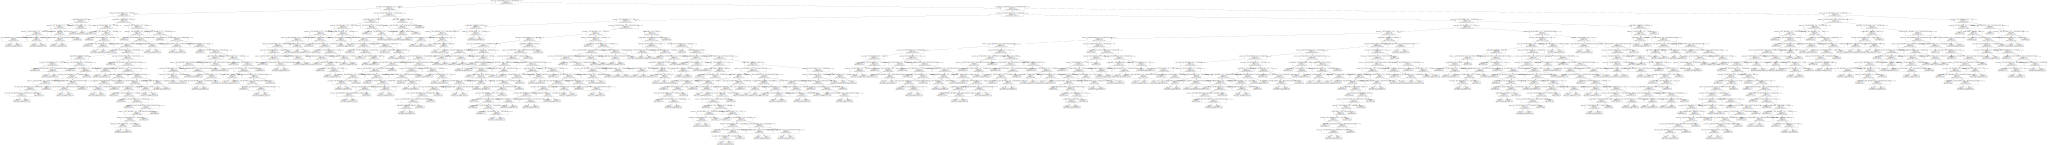

In [40]:
# code to plot the desicion tree
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(baseline_model.named_steps['model'], out_file="mytree.dot", feature_names=feature_names_out)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [41]:
# extracting feature importances
feature_importances = baseline_model.named_steps['model'].feature_importances_

<Axes: >

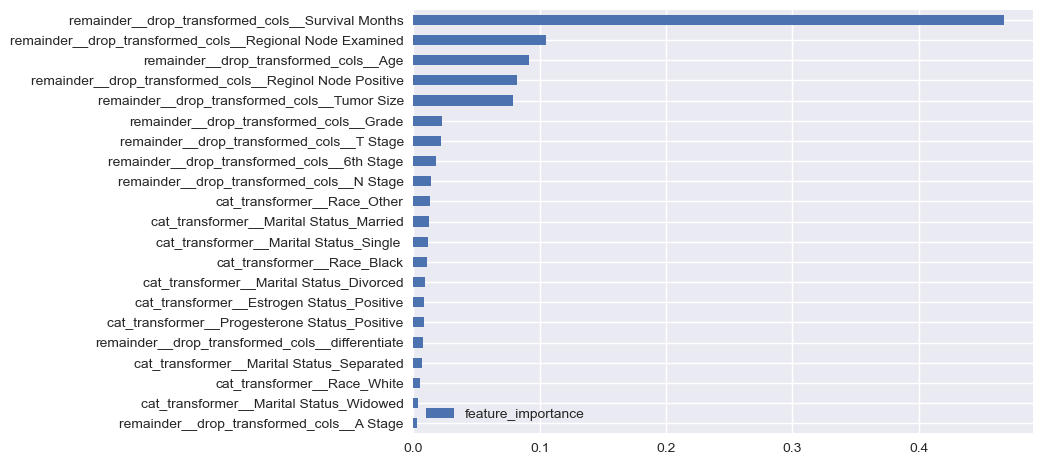

In [42]:
# plotting feature importances 
feature_importances_named = pd.DataFrame(feature_importances)
feature_importances_named = feature_importances_named
feature_importances_named.index = feature_names_out
feature_importances_named.columns = ['feature_importance']
feature_importances_named.sort_values('feature_importance', inplace=True, ascending=True)
feature_importances_named.plot(kind='barh')


In [43]:
# predict probabilities for ROC/AUC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

train_probs = baseline_model.predict_proba(features_train[baseline_features])[:,1] 
test_probs = baseline_model.predict_proba(features_test[baseline_features])[:, 1]
train_predictions = baseline_model.predict(features_train[baseline_features])
test_predictions = baseline_model.predict(features_test[baseline_features])

print(f'Train ROC AUC Score: {roc_auc_score(target_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(target_test, test_probs)}')

# the probability that a model will assign a larger probability 
# to a random positive example than to a random negative example

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.7748820248820248


Recall Baseline: 1.0 Test: 0.64 Train: 1.0
Precision Baseline: 0.17 Test: 0.59 Train: 1.0
Roc Baseline: 0.5 Test: 0.77 Train: 1.0


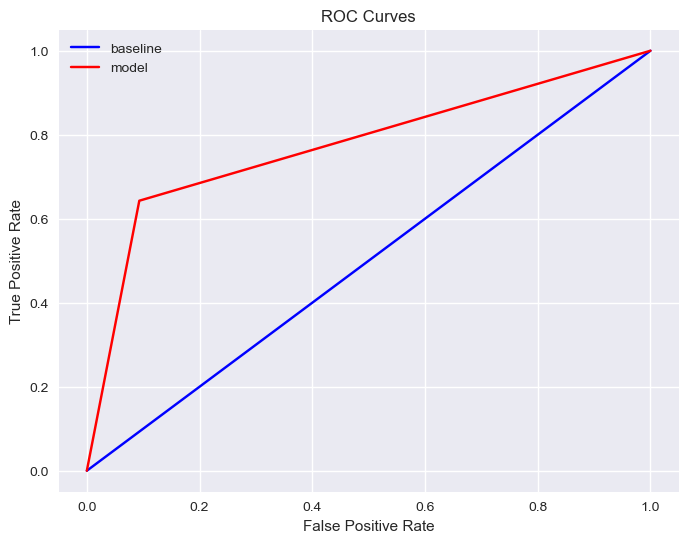

In [45]:
# function is from a thread at stackoverflow.com 
# function to plot ROC curve
def evaluate_model(test_predictions, test_probs, train_predictions, train_probs):    
    
    baseline = {}    
    baseline['recall']= recall_score(target_test,[1 for _ in range(len(target_test))])    
    baseline['precision'] = precision_score(target_test, [1 for _ in range(len(target_test))])
    baseline['roc'] = 0.5    
    
    results = {}    
    results['recall'] = recall_score(target_test, test_predictions)    
    results['precision'] = precision_score(target_test, test_predictions)    
    results['roc'] = roc_auc_score(target_test, test_probs)    
    
    train_results = {}
    train_results['recall'] = recall_score(target_train, train_predictions)    
    train_results['precision'] = precision_score(target_train, train_predictions)
    train_results['roc'] = roc_auc_score(target_train, train_probs)    
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates    
    base_fpr, base_tpr, _ = roc_curve(target_test, [1 for _ in range(len(target_test))])    
    model_fpr, model_tpr, _ = roc_curve(target_test, test_probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves    
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();    
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); 
    plt.title('ROC Curves');
    plt.show();

evaluate_model(test_predictions, test_probs, train_predictions, train_probs)

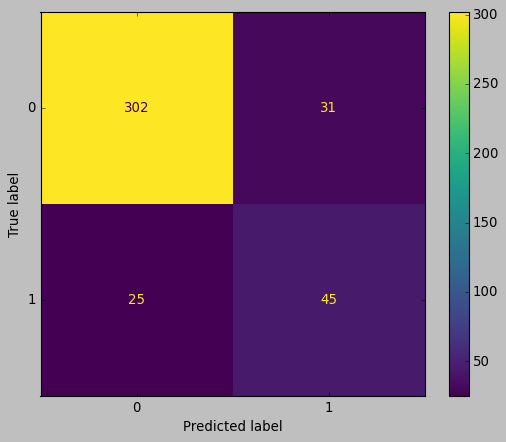

In [46]:
# confusion matrix for predictions on test data
plt.style.use('classic')
confusion_matrix(target_test, test_predictions)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(baseline_model, features_test[baseline_features], target_test);

In [55]:
# gridsearch RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# choosing features for baseline model
baseline_features = num_cols + cat_cols

# setting up pipeline for OneHotEncoding and passthrough of num_cols
# the col_dropper ColumnTransformer is used to drop the columns that were OneHotEncoded, as they are
# no longer needed. 
ohe_transformer = OneHotEncoder(drop='if_binary')
transformer = ColumnTransformer([('cat_transformer', ohe_transformer, cat_cols)
                                ], remainder='passthrough')

col_dropper = ColumnTransformer([('drop_transformed_cols', 'passthrough', num_cols)],
                                remainder='drop'
                               )

corr_transformer = ColumnTransformer([('cat_transformer', ohe_transformer, cat_cols)],
                                     remainder=col_dropper
                                    )

# creating model instance
model_rfc = RandomForestClassifier(class_weight='balanced', 
                                   random_state=42, 
                                   n_jobs=-1
                                  )

# creating baseline model pipeline
baseline_model = Pipeline([('corr_transformer', corr_transformer),
                           ('model', model_rfc)])

search_space_rfc = {'model__max_depth': np.geomspace(start=10, stop=100, num=6, dtype='int'),
                   'model__min_samples_leaf': np.geomspace(start=3, stop=40, num=6, dtype='int'),
                    'model__n_estimators': np.geomspace(start=50, stop=300, num=6, dtype='int')}

model_rfc = GridSearchCV(estimator=baseline_model,
                        param_grid=search_space_rfc,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)

# fitting model
model_rfc.fit(features_train[baseline_features], target_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('corr_transformer',
                                        ColumnTransformer(remainder=ColumnTransformer(transformers=[('drop_transformed_cols',
                                                                                                     'passthrough',
                                                                                                     ['Age',
                                                                                                      'T '
                                                                                                      'Stage',
                                                                                                      'N '
                                                                                                      'Stage',
                                                                                                      '6th '
                                                                                                      'Stage',
                                                                                                      'differentiate',
                                                                                                      'Grade',
                                                                                                      'A '
                                                                                                      'Stage',
                                                                                                      'Tumor '
                                                                                                      'Size',
                                                                                                      'Regional '
                                                                                                      'Node '
                                                                                                      'Examined',
                                                                                                      'Reginol '
                                                                                                      'Node '
                                                                                                      'Positive',
                                                                                                      'Survival '
                                                                                                      'Months'])]),
                                                          transformers=[('cat_...
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Race',
                                                                          'Marital '
                                                                          'Status',
                                                                          'Estrogen '
                                                                          'Status',
                                                                          'Progesterone '
                                                                          'Status'])])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([ 10,  15,  25,  39,  63, 100]),
                         'model__min_samples_leaf': array([ 3,  5,  8, 14, 23, 40]),
                         'model__n_estimators': array([ 50,  71,

In [56]:
# predict and evaluate on test set
print(model_rfc.best_estimator_)

recall = recall_score(target_test, model_rfc.best_estimator_.predict(features_test[baseline_features]))
precision = precision_score(target_test, model_rfc.best_estimator_.predict(features_test[baseline_features]))
f1 = f1_score(target_test, model_rfc.best_estimator_.predict(features_test[baseline_features]))
accuracy = accuracy_score(target_test, model_rfc.best_estimator_.predict(features_test[baseline_features]))
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1: {f1}')
print(f'accuracy: {accuracy}')

Pipeline(steps=[('corr_transformer',
                 ColumnTransformer(remainder=ColumnTransformer(transformers=[('drop_transformed_cols',
                                                                              'passthrough',
                                                                              ['Age',
                                                                               'T '
                                                                               'Stage',
                                                                               'N '
                                                                               'Stage',
                                                                               '6th '
                                                                               'Stage',
                                                                               'differentiate',
                                                                   